이번 분석은 RFM 프레임워크를 이용한 유저 분류 및 이탈 예측을 포함하였다.

## Table of Contents
1. [Data Load](#data-load)
2. [Customer Analysis](#customer-analysis)
3. [Cohort Analysis](#cohort-analysis)
4. [RFM Analysis](#rfm-analysis)
5. [RFMT Survival Analysis](#rfmt-survival-analysis)

<a id='data-load'></a>
# Data Load

In [965]:
import pandas as pd
# url = 'https://archive.ics.uci.edu/dataset/352/online+retail'
file_path = './Online Retail.xlsx'

df = pd.read_excel(file_path)
df.sample(frac=1.0).to_csv('./Online Retail.csv',index=False)
file_path = './Online Retail.csv'

df = pd.read_csv(file_path)

- sample anaylsis data (반복 분석을 빠르게 하기 위해 데이터 resizing이 필요할 수 있으며 draft 분석을 위해 사용하였다. 

In [882]:
df.sample(frac=0.3).to_csv('./Online Retail_mini.csv',index=False)
file_path = './Online Retail_mini.csv'
df = pd.read_csv(file_path)
#or

<a id='customer-analysis'></a>
# Customer Analysis

In [883]:
import matplotlib.pyplot as plt
import seaborn as sns
print("number of customers: ",df.CustomerID.nunique())
print("Shape: ",df.shape)
print('Missing values:', df.isnull().sum())
print('Summary statistics:\n', df.describe())
print('Unique values:\n', df.nunique())

number of customers:  4212
Shape:  (162573, 8)
Missing values: InvoiceNo          0
StockCode          0
Description      442
Quantity           0
InvoiceDate        0
UnitPrice          0
CustomerID     40476
Country            0
dtype: int64
Summary statistics:
             Quantity      UnitPrice     CustomerID
count  162573.000000  162573.000000  122097.000000
mean       10.264060       4.409724   15286.313030
std       195.244405      85.862218    1714.262968
min     -9600.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13949.000000
50%         3.000000       2.080000   15150.000000
75%        10.000000       4.130000   16790.000000
max     74215.000000   17836.460000   18287.000000
Unique values:
 InvoiceNo      20163
StockCode       3768
Description     3843
Quantity         442
InvoiceDate    18690
UnitPrice        756
CustomerID      4212
Country           38
dtype: int64


In [884]:
df.groupby("CustomerID")[["Quantity","UnitPrice"]].sum().sort_values(by="Quantity",ascending=False).tail(10)

,Quantity,UnitPrice
CustomerID,,
18087.0,-96,0.85
14213.0,-98,14.40
17307.0,-144,1.06
12454.0,-168,25.43
15823.0,-179,36.79
16742.0,-187,468.90
12427.0,-239,19.69
13984.0,-290,7.06
16546.0,-368,10.84


In [885]:
# 음의 구매량은 제외한다.
df = df[df.Quantity > 0]

In [886]:
df['CustomerID'] = df['CustomerID'].fillna(0)

In [887]:
df['CustomerID'] = df['CustomerID'].astype(int)

In [888]:
# customer id가 0인 데이터는 제외한다.
df = df[df.CustomerID != 0]

- 음의 구매량이 없는 데이터로 확인된 결과

In [889]:
df_groupby = df.groupby("CustomerID")[["Quantity","UnitPrice"]].sum().sort_values(by="Quantity",ascending=False)

- 고객 당 평균 구매 횟수

In [890]:
df.groupby("CustomerID")[["InvoiceNo"]].count().mean()

InvoiceNo    28.479838
dtype: float64

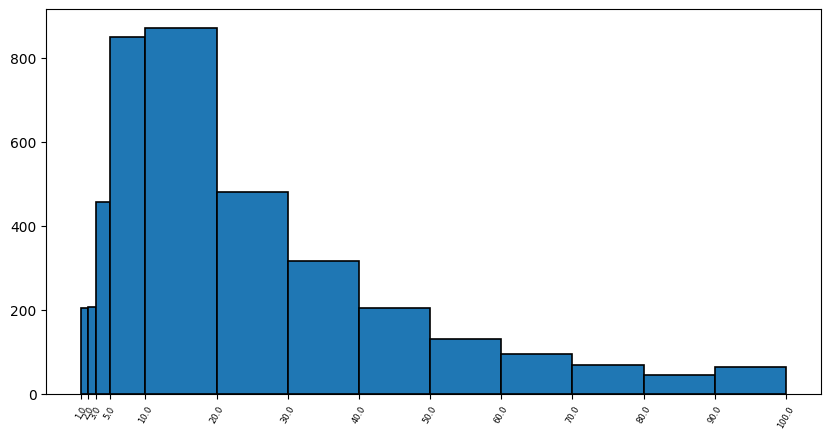

In [891]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

# Prepare the data
data = df.groupby("CustomerID")[["InvoiceNo"]].count().sort_values(by="InvoiceNo",ascending=False)

# Define the bins
bins = [1,2,3,5,10,20,30,40,50,60,70,80,90,100]

# Create the histogram and get the bin edges
counts, edges, patches = plt.hist(data['InvoiceNo'], bins=bins, edgecolor='black', linewidth=1.2)

# Calculate the center of the bins
#centers = (edges[:-1] + edges[1:]) / 2

# Set the x-ticks and x-tick labels to be the center of the bins
plt.xticks(edges, labels=[f'{center:.1f}' for center in edges], rotation=60, fontsize=6)

# Show the plot
plt.show()

- 약 80퍼센트의 고객은 37번 이하의 구매 반복(frequency) 횟수를 가지고 있음

In [892]:
df.groupby("CustomerID")[["InvoiceNo"]].count().sort_values(by="InvoiceNo",ascending=True).quantile(0.8)

InvoiceNo    38.0
Name: 0.8, dtype: float64

- 고객 평균 구매 물품 개수(Unit) 및 평균 구매 물품(Unit) 단가

In [893]:
df.groupby("CustomerID")[["Quantity","UnitPrice"]].sum().mean()

Quantity     386.883560
UnitPrice     90.415856
dtype: float64

In [894]:
df_groupby.median()

Quantity     116.00
UnitPrice     39.22
dtype: float64

In [895]:
quantity_price = df.groupby("CustomerID")[["Quantity","UnitPrice"]].sum().sort_values(by="Quantity",ascending=False)

- 고객 구매수량과 구매단가의 상관관계

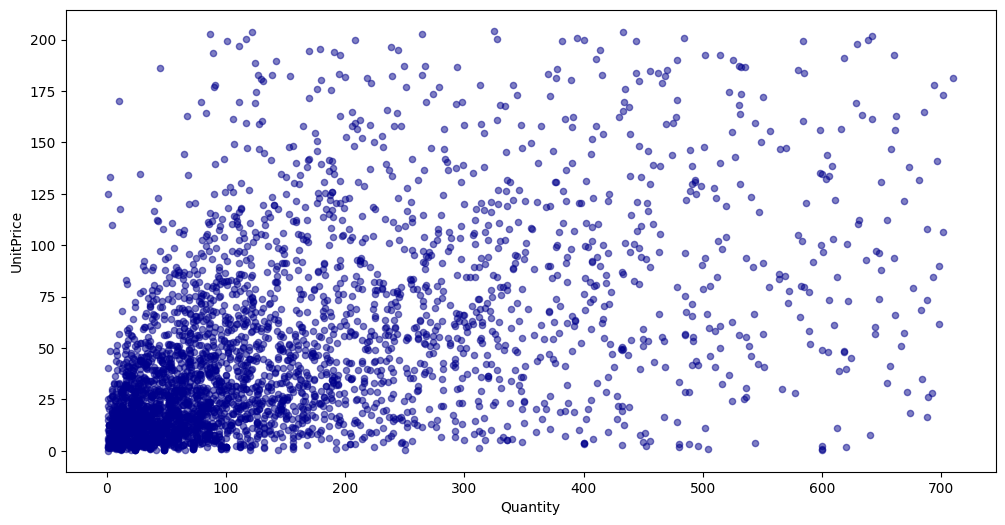

In [896]:
import matplotlib.pyplot as plt

# Calculate Q1, Q2 and IQR for Quantity and UnitPrice
Q1_quantity = quantity_price['Quantity'].quantile(0.25)
Q3_quantity = quantity_price['Quantity'].quantile(0.75)
IQR_quantity = Q3_quantity - Q1_quantity

Q1_unitprice = quantity_price['UnitPrice'].quantile(0.25)
Q3_unitprice = quantity_price['UnitPrice'].quantile(0.75)
IQR_unitprice = Q3_unitprice - Q1_unitprice

# Filter out the outliers
quantity_price_filtered = quantity_price[(quantity_price['Quantity'] >= Q1_quantity - 1.5*IQR_quantity) & 
                 (quantity_price['Quantity'] <= Q3_quantity + 1.5*IQR_quantity) &
                 (quantity_price['UnitPrice'] >= Q1_unitprice - 1.5*IQR_unitprice) & 
                 (quantity_price['UnitPrice'] <= Q3_unitprice + 1.5*IQR_unitprice)]

# Create the scatter plot
quantity_price_filtered.plot(kind='scatter', x='Quantity', y='UnitPrice', figsize=(12, 6), color='darkblue', alpha=0.5)

# Show the plot
plt.show()

- 고객 구매 수량 및 구매 단가의 분포

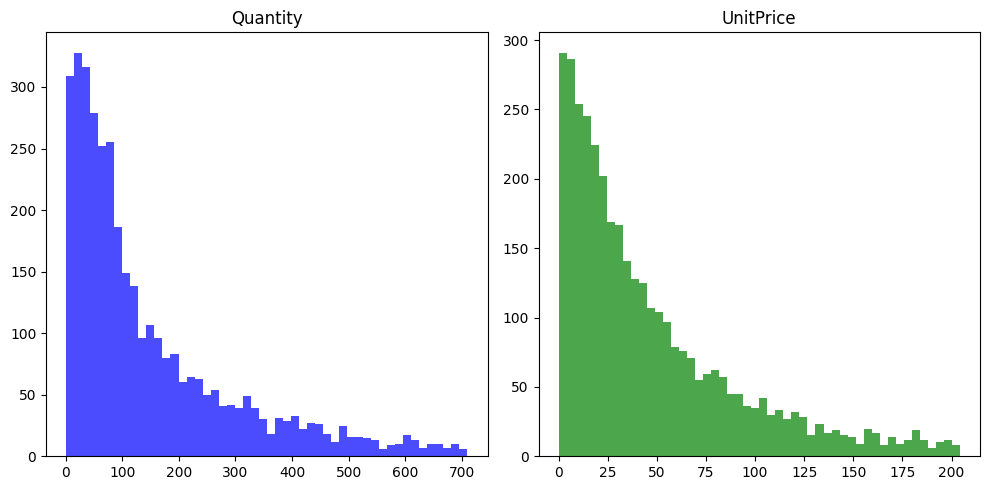

In [897]:
import matplotlib.pyplot as plt

# Create a figure with 2 subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Draw a histogram for Quantity in the first subplot
axs[0].hist(quantity_price_filtered['Quantity'], bins=50, color='blue', alpha=0.7)
axs[0].set_title('Quantity')

# Draw a histogram for UnitPrice in the second subplot
axs[1].hist(quantity_price_filtered['UnitPrice'], bins=50, color='green', alpha=0.7)
axs[1].set_title('UnitPrice')

# Display the plot
plt.tight_layout()
plt.show()

<Axes: xlabel='Quantity'>

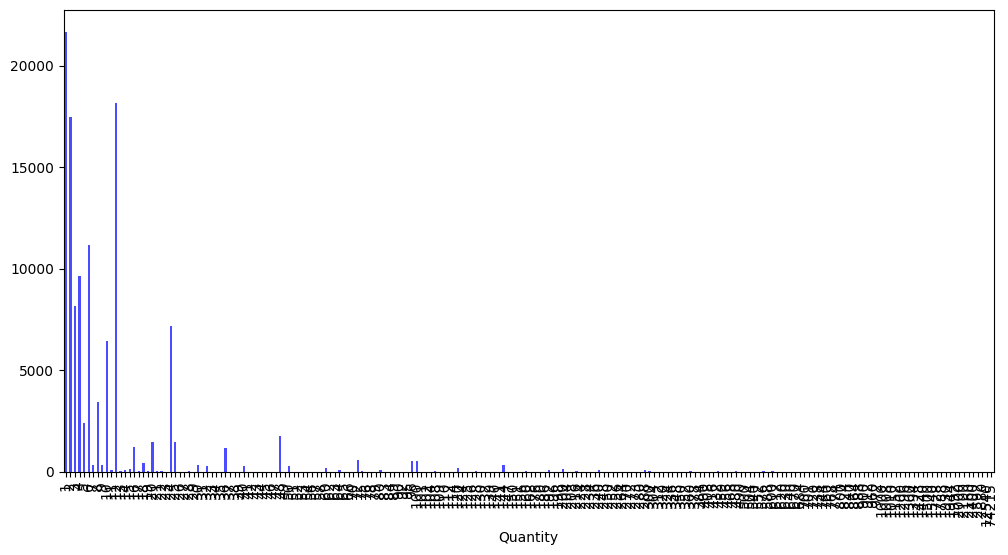

In [898]:
df.Quantity.value_counts().sort_index().plot(kind='bar', figsize=(12, 6), color='blue', alpha=0.7)

<a id='cohort-analysis'></a>
# 코호트 분석

In [899]:
# Convert InvoiceDate to datetime and extract the year and month
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceYearMonth'] = df['InvoiceDate'].dt.to_period('M')

# Create a DataFrame to identify the first purchase date of each customer
cohort_data = df.groupby('CustomerID')['InvoiceYearMonth'].min()
cohort_data = cohort_data.reset_index()
cohort_data.rename(columns={'InvoiceYearMonth': 'Cohort'}, inplace=True)

# Merge the cohort data with the main data
merged_data = pd.merge(df, cohort_data, how='left', on='CustomerID')

merged_data.tail()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Cohort
119354,565445,22573,STAR WOODEN CHRISTMAS DECORATION,5,2011-09-04 14:50:00,0.85,13548,United Kingdom,2011-09,2011-04
119355,554978,20677,PINK POLKADOT BOWL,8,2011-05-29 11:05:00,1.25,16889,United Kingdom,2011-05,2011-01
119356,574700,21705,BAG 500g SWIRLY MARBLES,2,2011-11-06 13:53:00,1.65,16033,United Kingdom,2011-11,2010-12
119357,579271,22979,PANTRY WASHING UP BRUSH,78,2011-11-29 09:56:00,1.65,17450,United Kingdom,2011-11,2011-01
119358,569229,22989,SET 2 PANTRY DESIGN TEA TOWELS,1,2011-10-02 14:56:00,3.25,14502,United Kingdom,2011-10,2011-01


In [900]:
# Calculate the difference in months
def get_month_diff(series):
    return (series['InvoiceYearMonth'] - series['Cohort']).n

merged_data['CohortIndex'] = merged_data.apply(get_month_diff, axis=1)

# Group by Cohort and CohortIndex
grouped = merged_data.groupby(['Cohort', 'CohortIndex'])

# Count the unique number of customers in each group
cohort_analysis = grouped['CustomerID'].nunique().reset_index()

# Pivot the data for better readability
cohort_analysis_pivot = cohort_analysis.pivot(index='Cohort', columns='CohortIndex', values='CustomerID')

# Display the first few rows of the cohort analysis pivot table
cohort_analysis_pivot


CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
Cohort,,,,,,,,,,,,,
2010-12,819.0,293.0,255.0,308.0,293.0,331.0,297.0,283.0,291.0,313.0,307.0,409.0,215.0
2011-01,400.0,84.0,106.0,90.0,118.0,105.0,103.0,99.0,118.0,123.0,144.0,48.0,NaN
2011-02,359.0,63.0,67.0,97.0,93.0,84.0,93.0,103.0,94.0,110.0,27.0,NaN,NaN
2011-03,435.0,66.0,109.0,80.0,97.0,72.0,113.0,99.0,119.0,39.0,NaN,NaN,NaN
2011-04,292.0,55.0,59.0,58.0,55.0,68.0,62.0,74.0,22.0,NaN,NaN,NaN,NaN
2011-05,281.0,47.0,44.0,50.0,57.0,65.0,76.0,25.0,NaN,NaN,NaN,NaN,NaN
2011-06,244.0,36.0,35.0,58.0,55.0,73.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,187.0,29.0,41.0,46.0,51.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,162.0,31.0,38.0,39.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- average 코호트 revisit ratio by CohortIndex

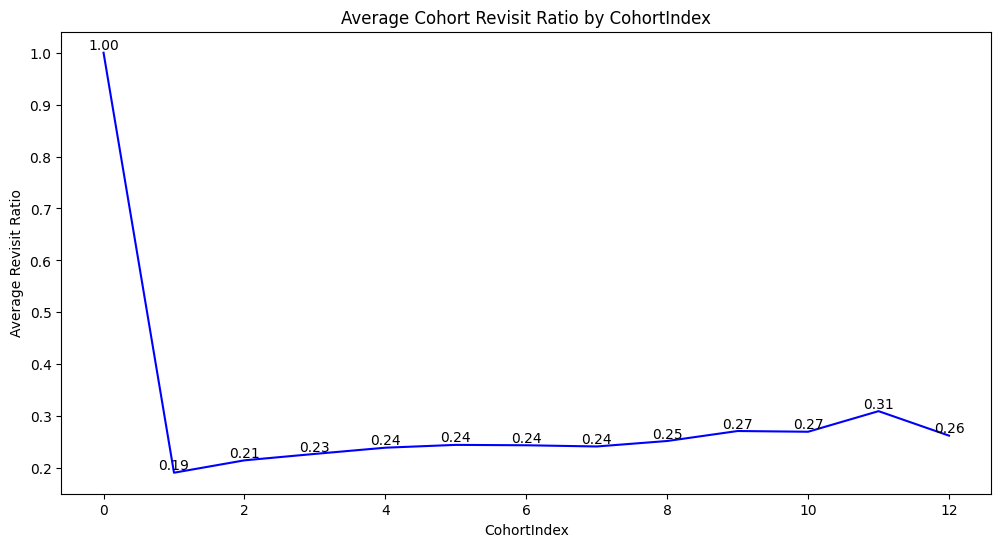

In [901]:
import matplotlib.pyplot as plt

cohort_analysis_pivot_percentiles = cohort_analysis_pivot.apply(lambda x: x / x[0], axis=1)
# Calculate the average cohort revisit ratio
average_revisit_ratio = cohort_analysis_pivot_percentiles.mean()

# Create the line plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(average_revisit_ratio, color='blue')

# Add labels to the data points
for x, y in enumerate(average_revisit_ratio):
    ax.text(x, y, f'{y:.2f}', color='black', ha='center', va='bottom')

# Set the title and labels
ax.set_title('Average Cohort Revisit Ratio by CohortIndex')
ax.set_xlabel('CohortIndex')
ax.set_ylabel('Average Revisit Ratio')

# Show the plot
plt.show()

In [902]:
np.mean(average_revisit_ratio[1:])

0.24741591074585778

- 고객 평균 구매 주기

In [903]:
# Calculating the average purchase time gap for each customer in days
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Group by CustomerID and calculate the average time gap in days
def calculate_average_gap(group):
    if len(group) <= 1:
        return None  # No gap for customers with only one purchase
    sorted_dates = group.sort_values()
    sorted_dates.drop_duplicates(inplace=True)  # Drop duplicates
    gaps = sorted_dates.diff().dt.days  # Calculate the difference in days
    average_gap = gaps.mean()  # Average gap
    return average_gap

frequency_per_customer = df.groupby('CustomerID')['InvoiceDate'].apply(calculate_average_gap)

# Calculate the overall average frequency across all customers
overall_average_frequency = frequency_per_customer.mean()

overall_average_frequency, frequency_per_customer.head()

(76.35352096722477,
 CustomerID
 12346          NaN
 12347    60.333333
 12348    54.500000
 12349          NaN
 12350          NaN
 Name: InvoiceDate, dtype: float64)

In [904]:
overall_average_frequency

76.35352096722477

In [905]:
# one example
df[df.CustomerID == 12347].sort_values(by="InvoiceDate").groupby("CustomerID")["InvoiceDate"].apply(calculate_average_gap)

CustomerID
12347    60.333333
Name: InvoiceDate, dtype: float64

<Axes: >

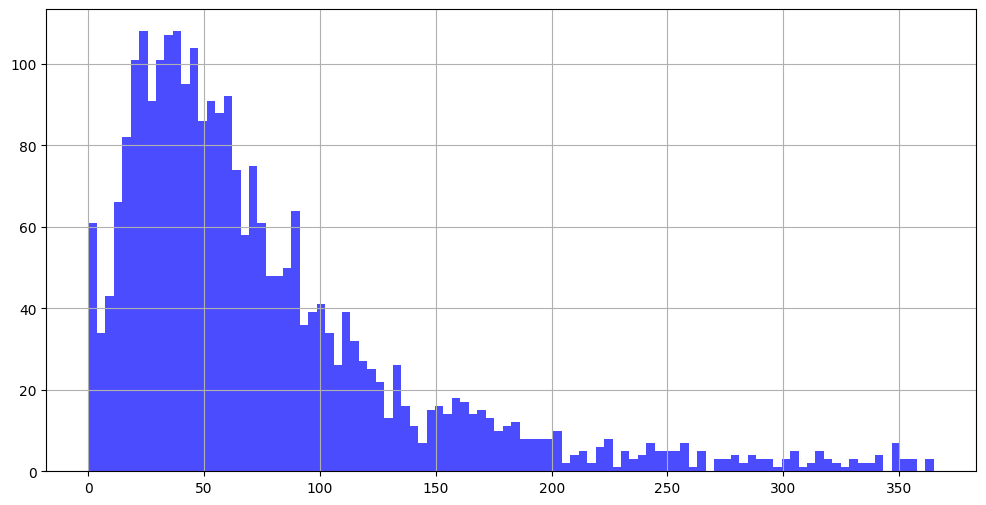

In [906]:
frequency_per_customer.dropna().hist(bins=100, figsize=(12, 6), color='blue', alpha=0.7)

<a id='rfm-analysis'></a>
# RFM 분석

In [907]:
from datetime import timedelta

In [908]:
df['TotalSum'] = df['Quantity'] * df['UnitPrice']

In [909]:
df['InvoiceYearMonthDate'] = df['InvoiceDate'].dt.to_period('D')


In [910]:
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)
print(snapshot_date)

2011-12-10 12:50:00


In [911]:
# 같은 날짜의 여러 건의 구매에 관하여 한 건으로 처리 하였음 (InvoiceYearMonthDate)
FMCG_Preprocess = df.groupby(['CustomerID']).agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'InvoiceYearMonthDate': lambda x : x.nunique(),
        'TotalSum': 'sum'})

In [912]:
FMCG_Preprocess.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceYearMonthDate': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)


In [913]:
print(FMCG_Preprocess.head())
print('{:,} rows; {:,} columns'
      .format(FMCG_Preprocess.shape[0], FMCG_Preprocess.shape[1]))

            Recency  Frequency  MonetaryValue
CustomerID                                   
12346           326          1       77183.60
12347             2          7        1335.75
12348           249          3         293.44
12349            19          1         694.56
12350           310          1         179.20
4,191 rows; 3 columns


/var/folders/b3/45r_hfx936j28b1nc2ng7grm0000gn/T/ipykernel_16720/655554231.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.subplot(3, 1, 1); sns.distplot(FMCG_Preprocess['Recency'])
/var/folders/b3/45r_hfx936j28b1nc2ng7grm0000gn/T/ipykernel_16720/655554231.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.s

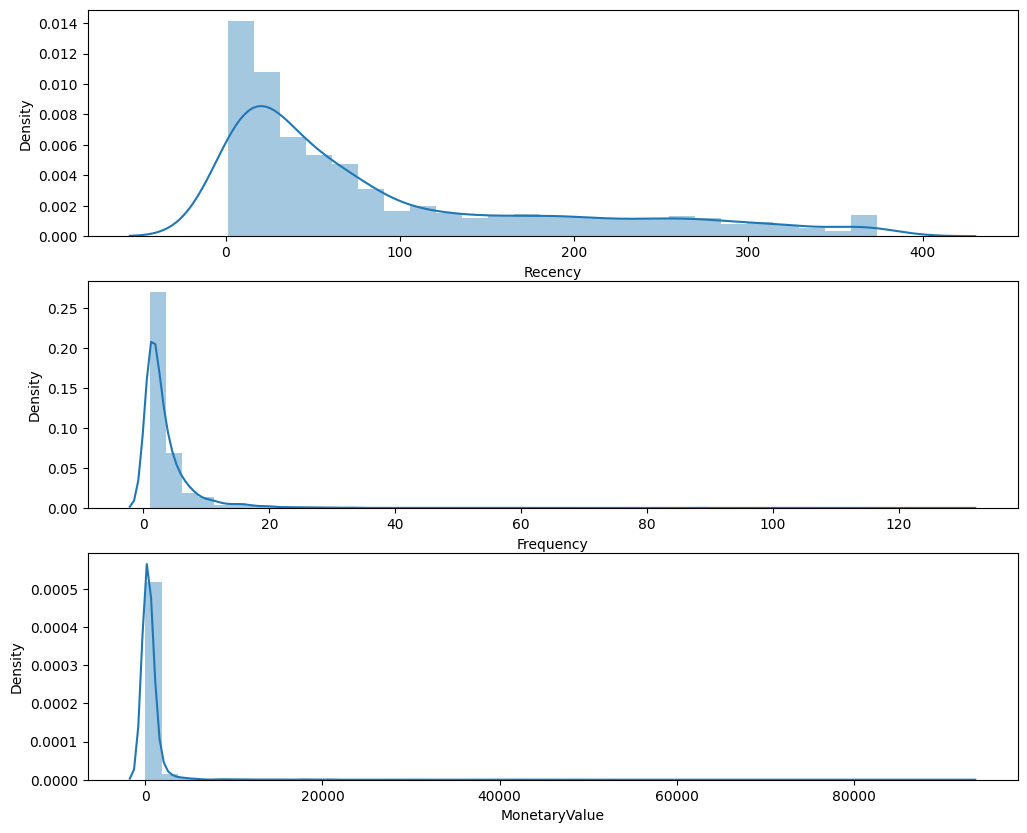

In [914]:
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(FMCG_Preprocess['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(FMCG_Preprocess['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(FMCG_Preprocess['MonetaryValue'])
# Show the plot
plt.show()

In [915]:
FMCG_Preprocess.mean()

Recency           92.624672
Frequency          3.672632
MonetaryValue    655.926591
dtype: float64

<Axes: xlabel='Frequency'>

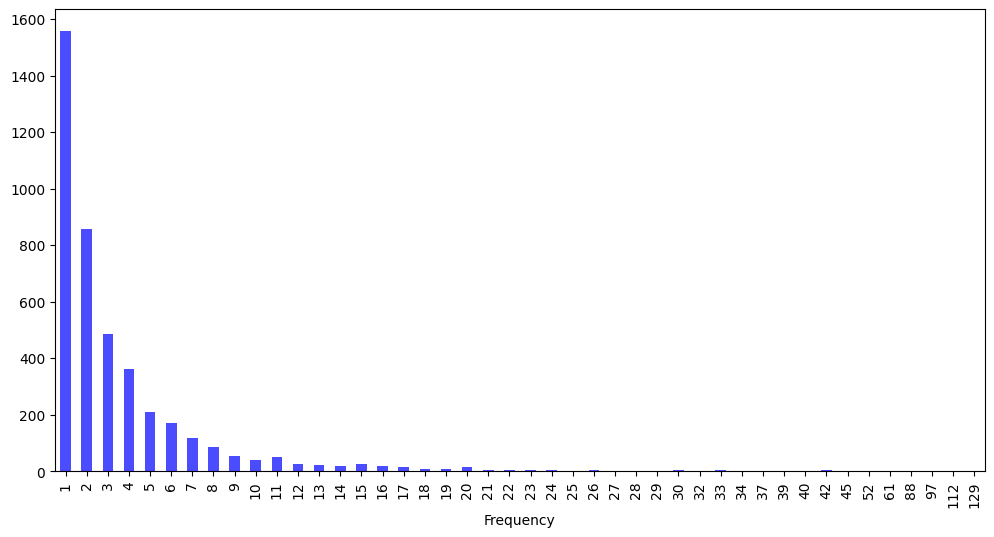

In [916]:
FMCG_Preprocess.Frequency.value_counts().sort_index().plot(kind='bar', figsize=(12, 6), color='blue', alpha=0.7)

Recency 와 Frequency 를 각각 4개, 5개의 구간으로 나누어서 라벨링

In [924]:
# Create labels for Recency and Frequency
r_labels = range(5, 0, -1); f_labels = range(1, 6)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(FMCG_Preprocess['Recency'], q=5, labels=r_labels,duplicates='drop')
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(FMCG_Preprocess['Frequency'], q=8, labels=f_labels,duplicates='drop')
# Create new columns R and F 
FMCG_Preprocess = FMCG_Preprocess.assign(R = r_groups.values, F = f_groups.values)
FMCG_Preprocess

,Recency,Frequency,MonetaryValue,M,R,F
CustomerID,,,,,,
12346,326,1,77183.60,4,1,1
12347,2,7,1335.75,4,5,4
12348,249,3,293.44,3,1,2
12349,19,1,694.56,4,4,1
12350,310,1,179.20,2,1,1
...,...,...,...,...,...,...
18280,278,1,53.85,1,1,1
18281,181,1,37.29,1,1,1
18282,8,2,72.65,1,5,1


MonetaryValue 에 대한 라벨링

In [925]:
m_labels = range(1, 5)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(FMCG_Preprocess['MonetaryValue'], q=4, labels=m_labels)
# Create new column M
FMCG_Preprocess = FMCG_Preprocess.assign(M = m_groups.values)
FMCG_Preprocess.head()

,Recency,Frequency,MonetaryValue,M,R,F
CustomerID,,,,,,
12346,326,1,77183.60,4,1,1
12347,2,7,1335.75,4,5,4
12348,249,3,293.44,3,1,2
12349,19,1,694.56,4,4,1
12350,310,1,179.20,2,1,1


Monetary 라벨과 R, F 라벨 합치기

In [926]:
def join_rfm(x): return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))
FMCG_Preprocess['RFM_Segment_Concat'] = FMCG_Preprocess.apply(join_rfm, axis=1)
FMCG_rfm = FMCG_Preprocess
FMCG_rfm.head()

,Recency,Frequency,MonetaryValue,M,R,F,RFM_Segment_Concat
CustomerID,,,,,,,
12346,326,1,77183.60,4,1,1,114
12347,2,7,1335.75,4,5,4,544
12348,249,3,293.44,3,1,2,123
12349,19,1,694.56,4,4,1,414
12350,310,1,179.20,2,1,1,112


전체 세그먼트 개수


In [927]:
FMCG_rfm_count_unique = FMCG_rfm.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print(FMCG_rfm_count_unique.sum())

81


## RFM 스코어

In [928]:
def join_rf(x): return str(int(x['R'])) + str(int(x['F']))

segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

FMCG_rfm['Segment'] = FMCG_rfm.apply(join_rf, axis=1)
FMCG_rfm['Segment'] = FMCG_rfm['Segment'].replace(segt_map, regex=True)
FMCG_rfm.head()

,Recency,Frequency,MonetaryValue,M,R,F,RFM_Segment_Concat,Segment
CustomerID,,,,,,,,
12346,326,1,77183.60,4,1,1,114,hibernating
12347,2,7,1335.75,4,5,4,544,champions
12348,249,3,293.44,3,1,2,123,hibernating
12349,19,1,694.56,4,4,1,414,promising
12350,310,1,179.20,2,1,1,112,hibernating


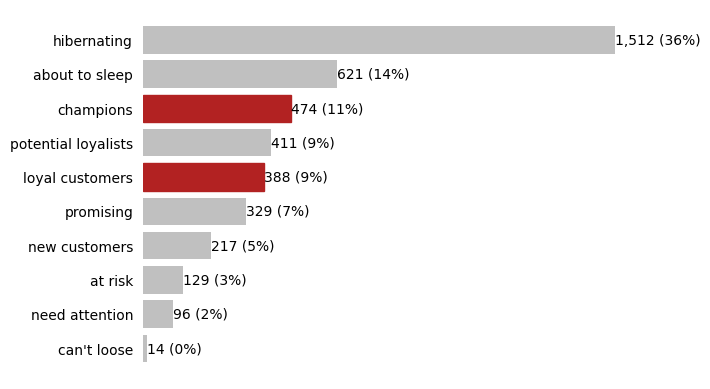

In [929]:
# count the number of customers in each segment
segments_counts = FMCG_rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()


In [930]:
FMCG_rfm[FMCG_rfm.Segment == 'hibernating']

,Recency,Frequency,MonetaryValue,M,R,F,RFM_Segment_Concat,Segment
CustomerID,,,,,,,,
12346,326,1,77183.60,4,1,1,114,hibernating
12348,249,3,293.44,3,1,2,123,hibernating
12350,310,1,179.20,2,1,1,112,hibernating
12354,232,1,330.23,3,1,1,113,hibernating
12355,214,1,93.00,2,1,1,112,hibernating
...,...,...,...,...,...,...,...,...
18262,140,1,28.76,1,2,1,211,hibernating
18269,366,1,20.10,1,1,1,111,hibernating
18278,74,1,94.40,2,2,1,212,hibernating


In [931]:
FMCG_rfm_level_agg = FMCG_rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

FMCG_rfm_level_agg

Recency Frequency MonetaryValue      
                       mean      mean          mean count
Segment                                                  
about to sleep         53.2       1.7         218.3   621
at risk               128.7       4.7         643.5   129
can't loose           113.6      11.1        1010.0    14
champions               6.1      12.3        2614.6   474
hibernating           198.5       1.5         269.0  1512
loyal customers        32.7       7.6        1412.8   388
need attention         51.3       4.0         509.5    96
new customers           8.0       1.6         174.5   217
potential loyalists    16.2       3.5         437.5   411
promising              24.0       1.5         168.6   329

<a id='rfmt-survival-analysis'></a>
# RFMT Survival Analysis

In [932]:
import pandas as pd
import numpy as np
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix
from hyperopt import hp, fmin, tpe, rand, SparkTrials, STATUS_OK, space_eval, Trials


In [933]:
from lifetimes.utils import *
from lifetimes.plotting import *

In [934]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,TotalSum,InvoiceYearMonthDate
2,578296,47566,PARTY BUNTING,12,2011-11-23 14:51:00,4.95,16653,United Kingdom,2011-11,59.40,2011-11-23
4,542303,22700,BLACK AND WHITE DOG BOWL,6,2011-01-27 11:05:00,2.95,12539,Spain,2011-01,17.70,2011-01-27
5,574740,35599B,BLACK CHRISTMAS TREE 120CM,12,2011-11-06 16:07:00,1.95,12357,Switzerland,2011-11,23.40,2011-11-06
7,560937,22617,BAKING SET SPACEBOY DESIGN,1,2011-07-22 10:52:00,4.95,17920,United Kingdom,2011-07,4.95,2011-07-22
8,546562,22189,CREAM HEART CARD HOLDER,4,2011-03-15 10:45:00,3.95,16293,United Kingdom,2011-03,15.80,2011-03-15
...,...,...,...,...,...,...,...,...,...,...,...
162568,565445,22573,STAR WOODEN CHRISTMAS DECORATION,5,2011-09-04 14:50:00,0.85,13548,United Kingdom,2011-09,4.25,2011-09-04
162569,554978,20677,PINK POLKADOT BOWL,8,2011-05-29 11:05:00,1.25,16889,United Kingdom,2011-05,10.00,2011-05-29
162570,574700,21705,BAG 500g SWIRLY MARBLES,2,2011-11-06 13:53:00,1.65,16033,United Kingdom,2011-11,3.30,2011-11-06
162571,579271,22979,PANTRY WASHING UP BRUSH,78,2011-11-29 09:56:00,1.65,17450,United Kingdom,2011-11,128.70,2011-11-29


In [940]:
current_date = df['InvoiceDate'].max()

metrics_df = summary_data_from_transaction_data(df
                                          , customer_id_col = 'CustomerID'
                                          , datetime_col = 'InvoiceDate'
                                          , monetary_value_col='TotalSum'
                                          , observation_period_end=current_date)
metrics_df.head()


,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0.0,0.0,325.0,0.000000
12347,6.0,365.0,367.0,185.916667
12348,2.0,110.0,358.0,71.960000
12349,0.0,0.0,18.0,0.000000
12350,0.0,0.0,310.0,0.000000


In [941]:
holdout_days = 90
calibration_end_date = current_date - timedelta(days = holdout_days)

metrics_cal_df = calibration_and_holdout_data(df
                                          ,customer_id_col = 'CustomerID'
                                          ,datetime_col = 'InvoiceDate'
                                          ,calibration_period_end=calibration_end_date # train 데이터 기간
                                          ,observation_period_end=current_date         # 끝 기간
                                          ,monetary_value_col='TotalSum')

metrics_cal_df.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346,0.0,0.0,235.0,0.000000,0.0,0.000000,90.0
12347,4.0,238.0,277.0,168.090000,2.0,26.067059,90.0
12348,2.0,110.0,268.0,71.960000,0.0,0.000000,90.0
12350,0.0,0.0,220.0,0.000000,0.0,0.000000,90.0
12352,3.0,34.0,206.0,41.393333,3.0,19.587500,90.0


In [942]:
whole_filtered_df = metrics_df[metrics_df.frequency > 0]
filtered_df       = metrics_cal_df[metrics_cal_df.frequency_cal > 0]

l2 penalty 계산을 위한 parameter 튜닝 수행

In [943]:
# 평가 지표: default는 MSE
def score_model(actuals, predicted, metric='mse'):

    metric = metric.lower()

    # MSE / RMSE
    if metric=='mse' or metric=='rmse':
        val = np.sum(np.square(actuals-predicted))/actuals.shape[0]
    elif metric=='rmse':
        val = np.sqrt(val)
    # MAE
    elif metric=='mae':
        val = np.sum(np.abs(actuals-predicted))/actuals.shape[0]
    else:
        val = None

    return val

# BG/NBD 모형 평가
def evaluate_bgnbd_model(param):

    data   = inputs
    l2_reg = param

    # 모형 적합
    model = BetaGeoFitter(penalizer_coef=l2_reg)
    model.fit(data['frequency_cal'], data['recency_cal'], data['T_cal'])

    # 모형 평가
    frequency_actual = data['frequency_holdout']
    frequency_predicted = model.predict(data['duration_holdout']
                                        , data['frequency_cal']
                                        , data['recency_cal']
                                        , data['T_cal']
                                       )
    mse = score_model(frequency_actual, frequency_predicted, 'mse')

    return {'loss': mse, 'status': STATUS_OK}

# Gamma/Gamma 모델 평가
def evaluate_gg_model(param):

    data   = inputs
    l2_reg = param

    # GammaGamma 모형 적합
    model = GammaGammaFitter(penalizer_coef=l2_reg)
    model.fit(data['frequency_cal'], data['monetary_value_cal'])

    # 모형 평가
    monetary_actual = data['monetary_value_holdout']
    monetary_predicted = model.conditional_expected_average_profit(data['frequency_holdout'], data['monetary_value_holdout'])
    mse = score_model(monetary_actual, monetary_predicted, 'mse')

    # return score and status
    return {'loss': mse, 'status': STATUS_OK}

In [944]:
search_space = hp.uniform('l2', 0.0, 1.0)
algo = tpe.suggest
trials = Trials()
inputs = filtered_df

argmin = fmin(
  fn = evaluate_bgnbd_model, # 목적함수
  space = search_space,      # 파라미터 공간
  algo = algo,               # 최적화 알고리즘: Tree of Parzen Estimators (TPE)
  max_evals=100,             # 반복수
  trials=trials            
  )

l2_bgnbd = space_eval(search_space,argmin)
print(l2_bgnbd)



100%|██████████| 100/100 [00:12<00:00,  7.97trial/s, best loss: 2.9680407929004016]
0.9981270299299023


In [945]:
lifetimes_model = BetaGeoFitter(penalizer_coef=l2_bgnbd)
# calibration 데이터의 R,F,T로 모형 적합
lifetimes_model.fit(filtered_df['frequency_cal'], filtered_df['recency_cal'], filtered_df['T_cal']) 

# holdout 데이터로 모델 평가: F의 실제값과 예측값의 MSE
frequency_actual = filtered_df['frequency_holdout']
frequency_predicted = lifetimes_model.predict(filtered_df['duration_holdout']
                                    ,filtered_df['frequency_cal']
                                    , filtered_df['recency_cal']
                                    , filtered_df['T_cal'])
mse = score_model(frequency_actual, frequency_predicted, 'mse')
print('MSE: {0}'.format(mse))



MSE: 2.9680407929004016


In [946]:
lifetimes_model.summary


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.454051,0.010094,0.434267,0.473835
alpha,25.088627,1.092557,22.947215,27.230039
a,0.000311,0.000620,-0.000905,0.001526
b,0.008637,0.016352,-0.023412,0.040687


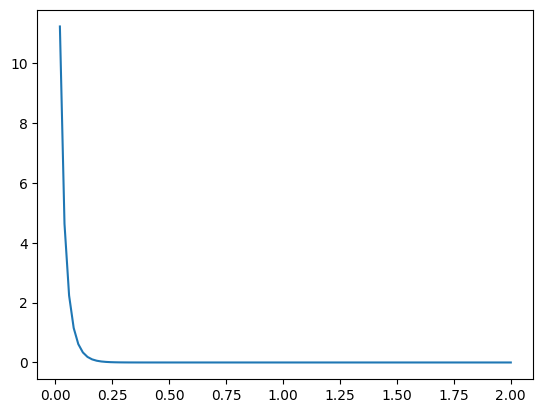

In [947]:
from scipy.stats import gamma, beta
import matplotlib.pyplot as plt

coefs = lifetimes_model.summary['coef']
x = np.linspace (0, 2, 100) 
y = gamma.pdf(x, a=coefs['r'], scale=1/coefs['alpha']) # BG/NBD에서의 모수 alpha는 scale 모수가 아닌 rate 모수이므로 역수!

plt.plot(x, y)

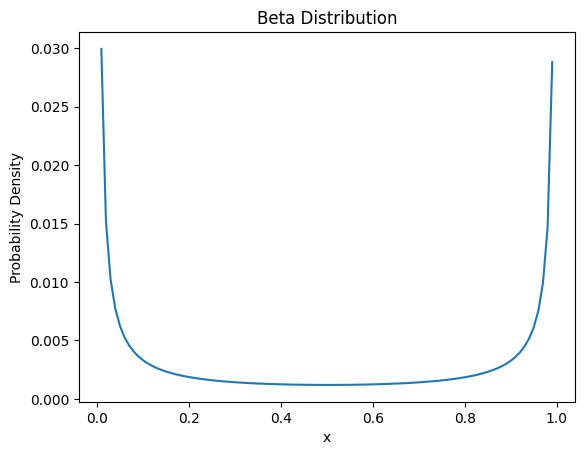

In [948]:
coefs = lifetimes_model.summary['coef']
x = np.linspace (0, 1, 100) 
y = beta.pdf(x, a=coefs['a'], b=coefs['b']) 
plt.title('Beta Distribution')
plt.ylabel('Probability Density')
plt.xlabel('x')
plt.plot(x, y)

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

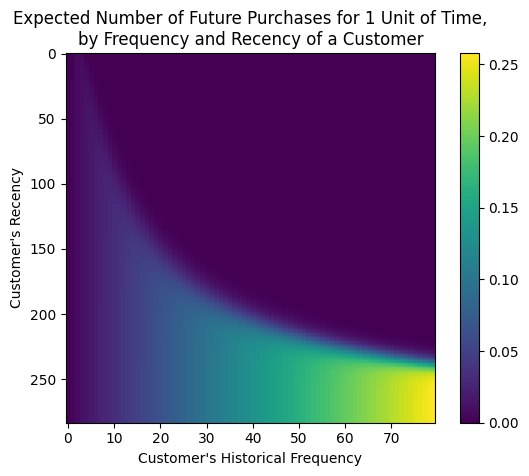

In [949]:
plot_frequency_recency_matrix(lifetimes_model)

ConversionError: Failed to convert value(s) to axis units: '2011-03-28 00:00:00'

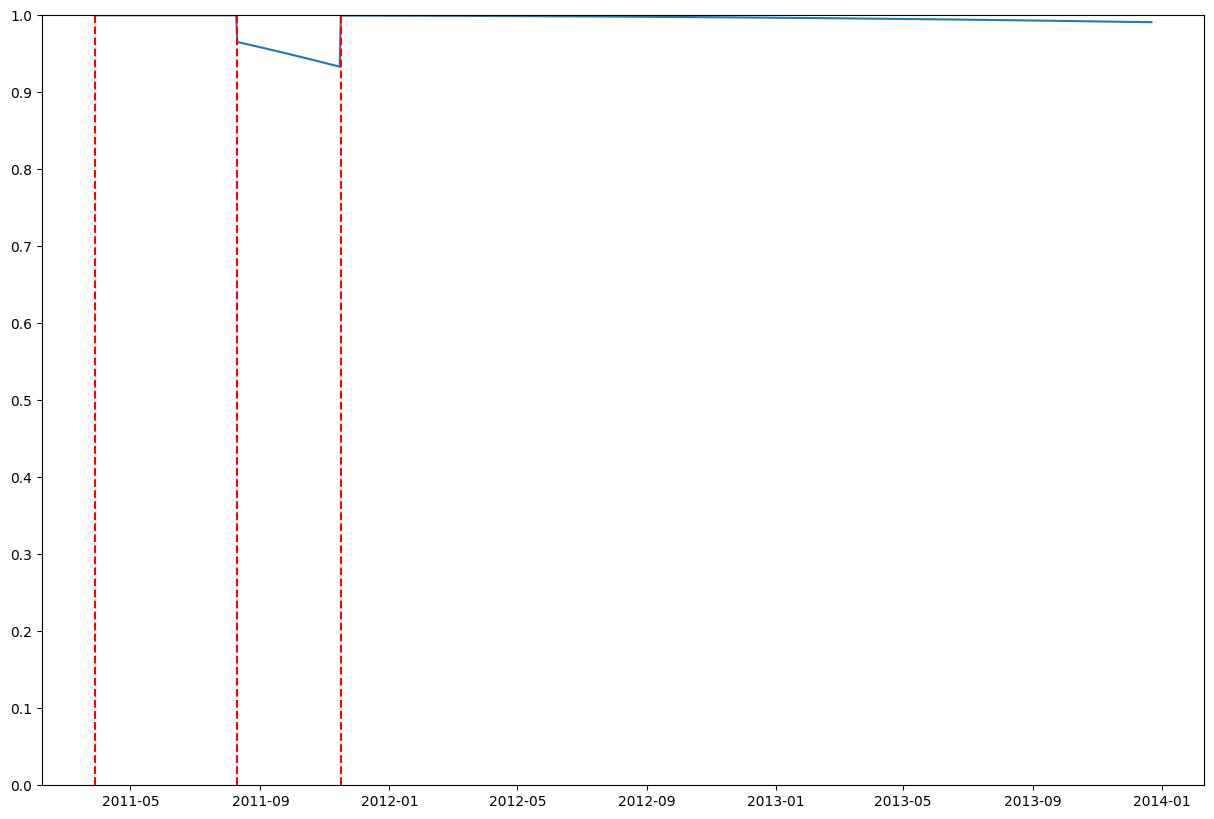

In [950]:
from lifetimes.plotting import plot_history_alive
fig, ax = plt.subplots(figsize=(15, 10))

# Select a customer
#customer_id = 12356  # replace with your actual customer ID
customer_id = np.random.choice(filtered_df.index)

# Get the customer's data
customer = df[df['CustomerID'] == customer_id][['CustomerID', 'InvoiceDate']]


#Calculate the customer's transaction history
customer_history = customer.sort_values(by="InvoiceDate")
customer_history.drop_duplicates(inplace=True)
customer_history.reset_index(drop=True, inplace=True)

#customer_history['InvoiceDate'] = customer_history['InvoiceDate'].dt.floor('D')
customer_history['InvoiceDate'] = customer_history['InvoiceDate'].dt.strftime(date_format = '%Y-%m-%d 00:00:00')

customer_history.rename(columns={'InvoiceDate': 'date','CustomerID':'id'}, inplace=True)
#customer_history.set_index('date', inplace=True)
#customer_history = customer_history.groupby('InvoiceDate').nth(0)
customer_history = customer_history.loc[:,['date','id']]
# Plot the probability of being alive
plot_history_alive(lifetimes_model, 1000, customer_history, 'date',freq='D',ax=ax)

ConversionError: Failed to convert value(s) to axis units: '2010-12-01 00:00:00'

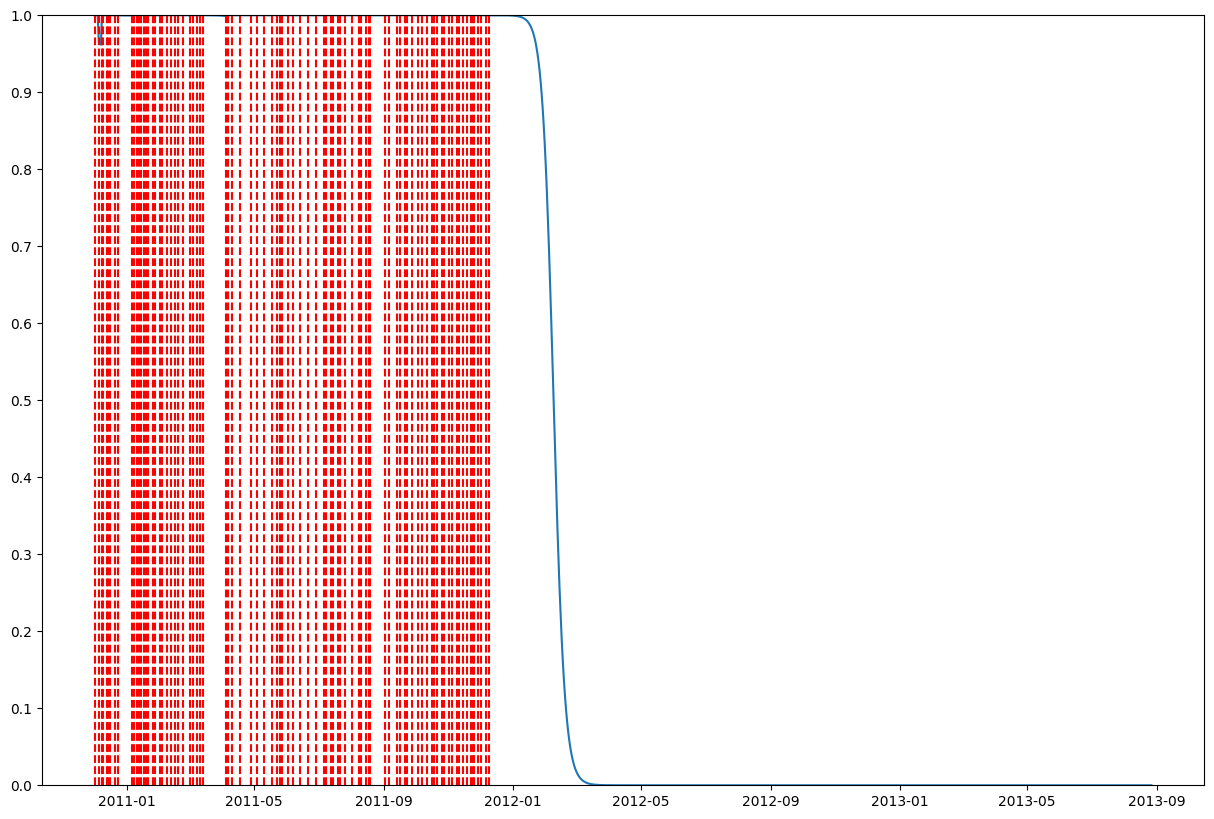

In [951]:
from lifetimes.plotting import plot_history_alive
fig, ax = plt.subplots(figsize=(15, 10))

# Select a customer
#customer_id = 12356  # replace with your actual customer ID
customer_id = np.random.choice(filtered_df.index)

# Get the customer's data
customer = df[df['CustomerID'] == customer_id][['CustomerID', 'InvoiceDate']]


#Calculate the customer's transaction history
customer_history = customer.sort_values(by="InvoiceDate")
customer_history.drop_duplicates(inplace=True)
customer_history.reset_index(drop=True, inplace=True)

#customer_history['InvoiceDate'] = customer_history['InvoiceDate'].dt.floor('D')
customer_history['InvoiceDate'] = customer_history['InvoiceDate'].dt.strftime(date_format = '%Y-%m-%d 00:00:00')

customer_history.rename(columns={'InvoiceDate': 'date','CustomerID':'id'}, inplace=True)
#customer_history.set_index('date', inplace=True)
#customer_history = customer_history.groupby('InvoiceDate').nth(0)
customer_history = customer_history.loc[:,['date','id']]
# Plot the probability of being alive
plot_history_alive(lifetimes_model, 1000, customer_history, 'date',freq='D',ax=ax)

ConversionError: Failed to convert value(s) to axis units: '2011-03-10 00:00:00'

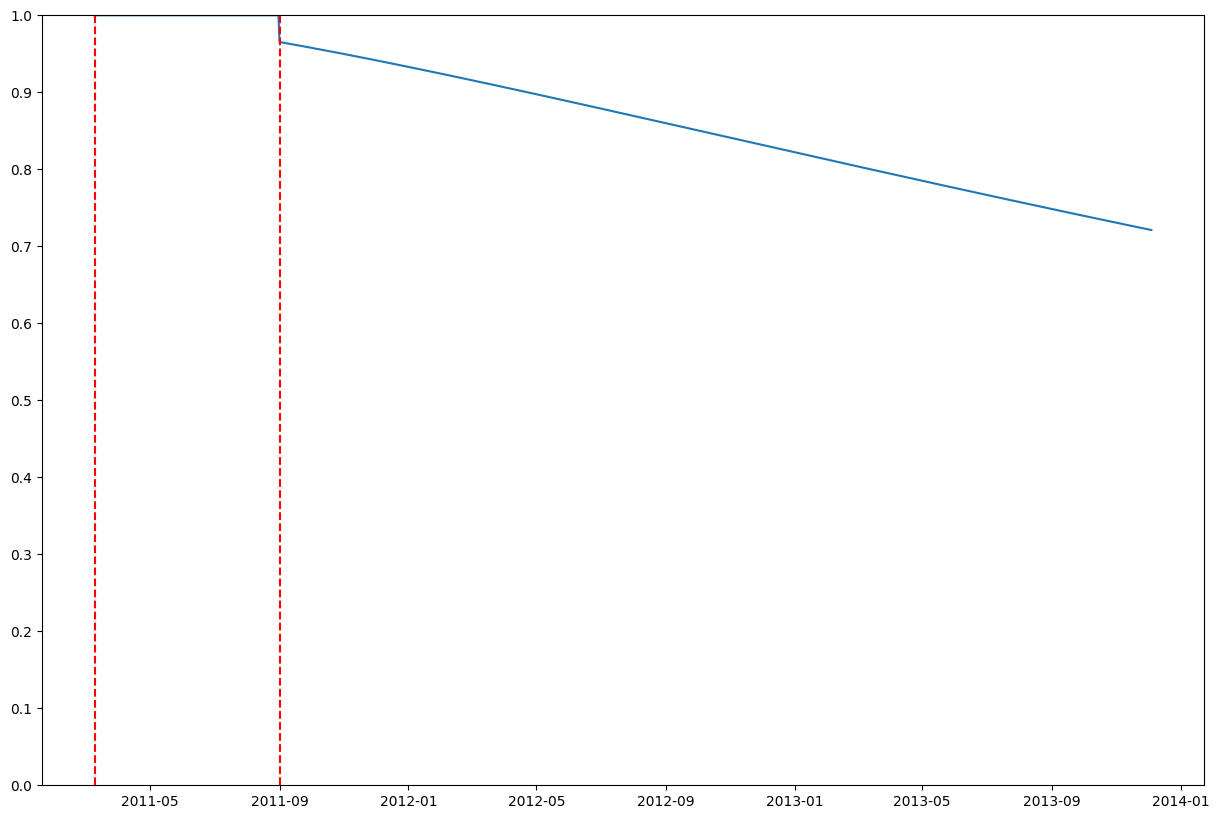

In [952]:
from lifetimes.plotting import plot_history_alive
fig, ax = plt.subplots(figsize=(15, 10))

# Select a customer
#customer_id = 12356  # replace with your actual customer ID
customer_id = np.random.choice(filtered_df.index)

# Get the customer's data
customer = df[df['CustomerID'] == customer_id][['CustomerID', 'InvoiceDate']]


#Calculate the customer's transaction history
customer_history = customer.sort_values(by="InvoiceDate")
customer_history.drop_duplicates(inplace=True)
customer_history.reset_index(drop=True, inplace=True)

#customer_history['InvoiceDate'] = customer_history['InvoiceDate'].dt.floor('D')
customer_history['InvoiceDate'] = customer_history['InvoiceDate'].dt.strftime(date_format = '%Y-%m-%d 00:00:00')

customer_history.rename(columns={'InvoiceDate': 'date','CustomerID':'id'}, inplace=True)
#customer_history.set_index('date', inplace=True)
#customer_history = customer_history.groupby('InvoiceDate').nth(0)
customer_history = customer_history.loc[:,['date','id']]
# Plot the probability of being alive
plot_history_alive(lifetimes_model, 1000, customer_history, 'date',freq='D',ax=ax)

ConversionError: Failed to convert value(s) to axis units: '2011-01-28 00:00:00'

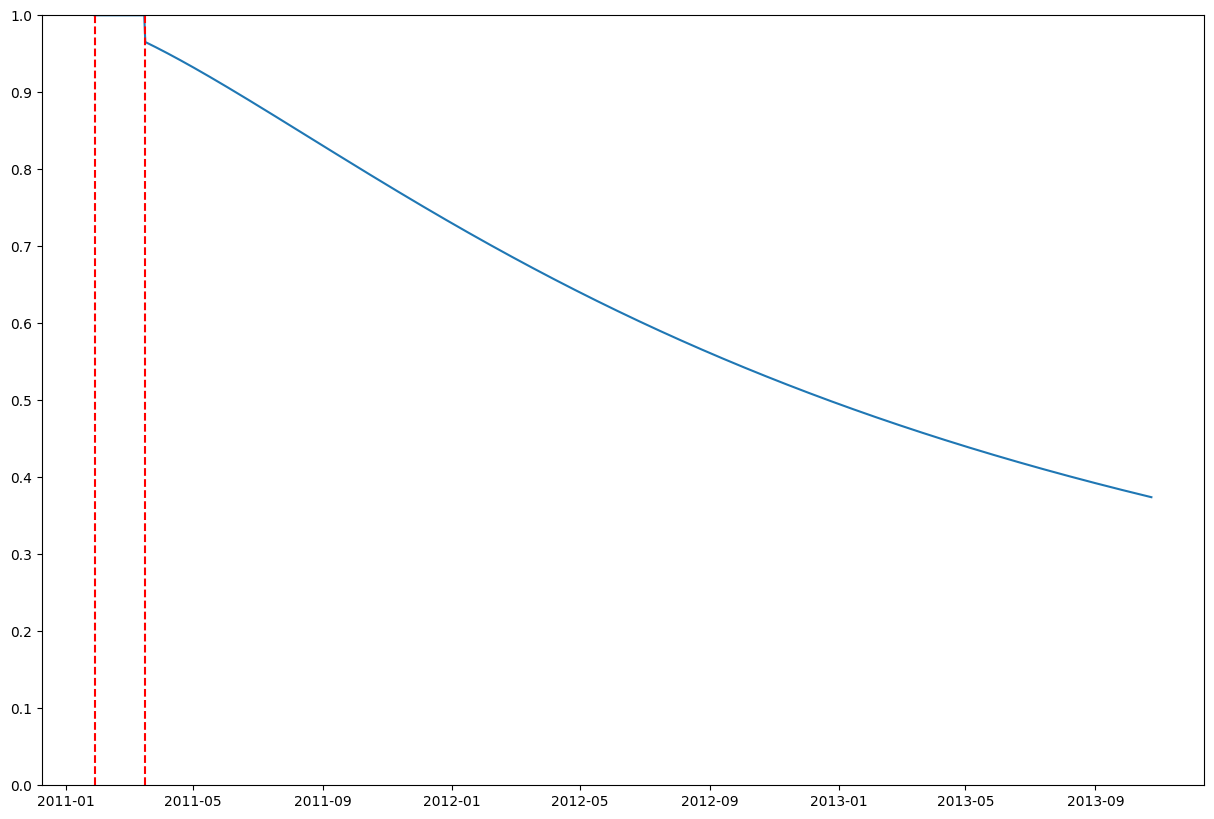

In [953]:
from lifetimes.plotting import plot_history_alive
fig, ax = plt.subplots(figsize=(15, 10))

# Select a customer
#customer_id = 12356  # replace with your actual customer ID
customer_id = np.random.choice(filtered_df.index)

# Get the customer's data
customer = df[df['CustomerID'] == customer_id][['CustomerID', 'InvoiceDate']]


#Calculate the customer's transaction history
customer_history = customer.sort_values(by="InvoiceDate")
customer_history.drop_duplicates(inplace=True)
customer_history.reset_index(drop=True, inplace=True)

#customer_history['InvoiceDate'] = customer_history['InvoiceDate'].dt.floor('D')
customer_history['InvoiceDate'] = customer_history['InvoiceDate'].dt.strftime(date_format = '%Y-%m-%d 00:00:00')

customer_history.rename(columns={'InvoiceDate': 'date','CustomerID':'id'}, inplace=True)
#customer_history.set_index('date', inplace=True)
#customer_history = customer_history.groupby('InvoiceDate').nth(0)
customer_history = customer_history.loc[:,['date','id']]
# Plot the probability of being alive
plot_history_alive(lifetimes_model, 1000, customer_history, 'date',freq='D',ax=ax)

## 고객 Segment별 집계

In [954]:
FMCG_rfm

,Recency,Frequency,MonetaryValue,M,R,F,RFM_Segment_Concat,Segment
CustomerID,,,,,,,,
12346,326,1,77183.60,4,1,1,114,hibernating
12347,2,7,1335.75,4,5,4,544,champions
12348,249,3,293.44,3,1,2,123,hibernating
12349,19,1,694.56,4,4,1,414,promising
12350,310,1,179.20,2,1,1,112,hibernating
...,...,...,...,...,...,...,...,...
18280,278,1,53.85,1,1,1,111,hibernating
18281,181,1,37.29,1,1,1,111,hibernating
18282,8,2,72.65,1,5,1,511,new customers


In [955]:
from tqdm import tqdm

In [956]:
def predict_all(raw): return lifetimes_model.predict(10, raw['frequency'], raw['recency'], raw['T'])

In [957]:
%%time
predict_series = metrics_df.apply(predict_all, axis=1)

CPU times: user 310 ms, sys: 5.69 ms, total: 315 ms
Wall time: 363 ms


In [958]:
metrics_df.mean()

frequency           2.672632
recency           128.023861
T                 220.168456
monetary_value     91.310442
dtype: float64

In [959]:
predict_series.name = 'predicted_purchases'

In [960]:
metrics_df.join(predict_series).head()

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
12346,0.0,0.0,325.0,0.000000,0.012960
12347,6.0,365.0,367.0,185.916667,0.164596
12348,2.0,110.0,358.0,71.960000,0.063806
12349,0.0,0.0,18.0,0.000000,0.104856
12350,0.0,0.0,310.0,0.000000,0.013540


In [961]:
predicted_segment = FMCG_rfm.join(predict_series)

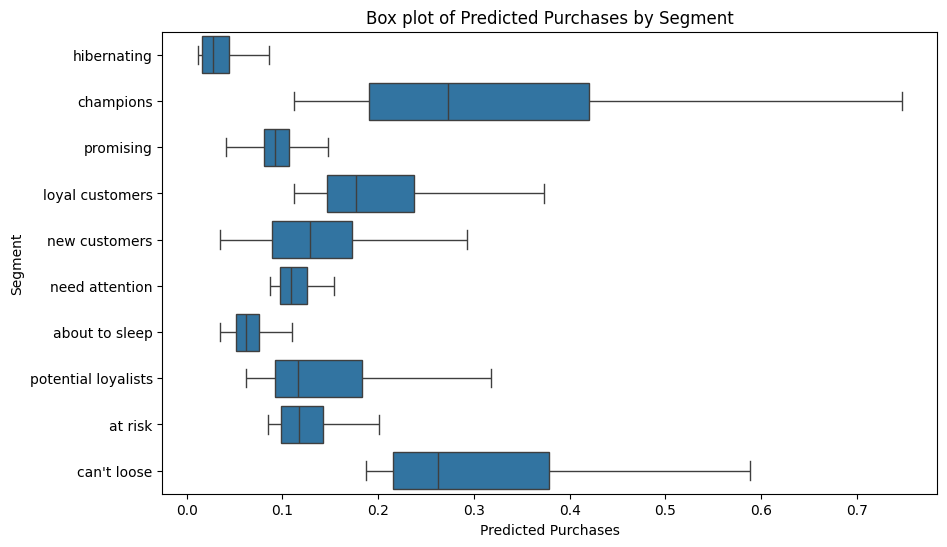

In [962]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(y='Segment', x='predicted_purchases', data=predicted_segment, orient='h',showfliers=False)
plt.title('Box plot of Predicted Purchases by Segment')
plt.ylabel('Segment')
plt.xlabel('Predicted Purchases')
plt.show()

In [963]:
predicted_segment

,Recency,Frequency,MonetaryValue,M,R,F,RFM_Segment_Concat,Segment,predicted_purchases
CustomerID,,,,,,,,,
12346,326,1,77183.60,4,1,1,114,hibernating,0.012960
12347,2,7,1335.75,4,5,4,544,champions,0.164596
12348,249,3,293.44,3,1,2,123,hibernating,0.063806
12349,19,1,694.56,4,4,1,414,promising,0.104856
12350,310,1,179.20,2,1,1,112,hibernating,0.013540
...,...,...,...,...,...,...,...,...,...
18280,278,1,53.85,1,1,1,111,hibernating,0.015018
18281,181,1,37.29,1,1,1,111,hibernating,0.022113
18282,8,2,72.65,1,5,1,511,new customers,0.092666


In [964]:
predicted_segment.groupby('Segment').agg({
    'predicted_purchases': ['mean', 'count'],
    'MonetaryValue': 'mean'
}).round(2)

predicted_purchases       MonetaryValue
                                   mean count          mean
Segment                                                    
about to sleep                     0.07   621        218.29
at risk                            0.13   129        643.49
can't loose                        0.30    14       1009.95
champions                          0.36   474       2614.63
hibernating                        0.03  1512        268.98
loyal customers                    0.21   388       1412.75
need attention                     0.12    96        509.51
new customers                      0.15   217        174.52
potential loyalists                0.16   411        437.54
promising                          0.10   329        168.63

# End of Document